In [2]:
import pandas as pd
import numpy as np
import praw
import tweepy as tw
import datetime
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import requests

import warnings
warnings.filterwarnings('ignore')

# Step 1: Collecting Keywords & Data 

### Keywords found using GPT 4 (LLM) from across news articles
##### The prompt engineered by us was to select keywords across 50 articles was:

Filter the below articles to 15 keywords into categories, searcher intent in ONE word, searcher volume bounded between 0 and 1, and frequency of the word being used bounded between 0 and 1.
Please categorize the articles below by selecting 15 keywords. Consider the searcher intent in a single word, the searcher volume ranging from 0 to 1, and the frequency of word usage ranging from 0 to 1.
Please list out the keywords in the following format.
KEYWORD, SEARCH INTENT, SEARCH VOLUME, KEYWORD FREQUENCY:
1.[KEYWORD 1],[SEARCH INTENT of the KEYWORD 1],[SEARCH VOLUME of the KEYWORD 1],[KEYWORD FREQUENCY of the KEYWORD 1] next line
2.[KEYWORD 2 ],[SEARCH INTENT of the KEYWORD 2],[SEARCH VOLUME of the KEYWORD 2],[KEYWORD FREQUENCY of the KEYWORD 2] next line
…
please do not give any additional description

In [21]:
KeyWordsCSV = pd.read_csv('KeyWords.csv')
KeyWordsDF = pd.DataFrame(KeyWordsCSV)
# Sort by Search Volume in descending order
KeyWordsDF = KeyWordsDF.sort_values(by=['Search Volume'], ascending=False)

In [22]:
KeyWordsDF = KeyWordsDF.drop(KeyWordsDF.columns[0], axis=1)
KeyWordsDF = KeyWordsDF.dropna()
KeyWordsDF = KeyWordsDF[KeyWordsDF['Search Volume'] >= 0.15]

def prepend_country(row):
    if ("Armenia" not in row[0]) and ("Azerbaijan" not in row[0]):
        return "Armenia " + row[0]
    else:
        return row[0]
    
def prepend_country2(row):
    if ("Armenia" not in row.iloc[0]) and ("Azerbaijan" not in row.iloc[0]):
        return "Azerbaijan " + row.iloc[0]
    else:
        return row.iloc[0]

KeyWordsDF_temp = KeyWordsDF.copy()
KeyWordsDF_temp['Keyword'] = KeyWordsDF_temp.apply(prepend_country, axis=1)

KeyWordsDF_temp2 = KeyWordsDF.copy()
KeyWordsDF_temp2['Keyword'] = KeyWordsDF_temp2.apply(prepend_country2, axis=1)

KeyWordsDF2 = pd.concat([KeyWordsDF_temp, KeyWordsDF_temp2])

#Remove Keyword duplicates by removing rows with the same Keyword
KeyWordsDF2 = KeyWordsDF2.drop_duplicates(subset=['Keyword'], keep='first')
KeyWordsDF2 = KeyWordsDF2.reset_index(drop=True)

print(KeyWordsDF2.count())
KeyWordsDF2.head(-5)

Keyword              226
Search Intent        226
Search Volume        226
Keyword Frequency    226
dtype: int64


,Keyword,Search Intent,Search Volume,Keyword Frequency
0,Armenia Nagorno-Karabakh conflict,Conflict analysis,0.99,0.8
1,Armenia Nagorno Karabakh,Conflict,0.90,0.4
2,Armenia Nagorno-Karabakh,Territory,0.90,0.2
3,Armenia-Azerbaijan,Comparison,0.90,1.0
4,Azerbaijan,Country,0.90,0.4
...,...,...,...,...
216,Azerbaijan Trans Adriatic Pipeline,Infrastructure,0.20,0.1
217,Azerbaijan Russian Empire,Historical Background,0.20,0.1
218,Azerbaijan Military budget,Informational,0.20,0.6
219,Azerbaijan Government spending,Informational,0.20,0.6


['Armenia Nagorno-Karabakh conflict', 'Armenia Nagorno Karabakh', 'Armenia Nagorno-Karabakh', 'Armenia-Azerbaijan', 'Azerbaijan', 'Armenia', 'Armenia Fighting', 'Armenia Propaganda', 'Armenia military', 'Azerbaijan military', 'Armenia and Azerbaijan', 'Armenia Shelling', 'Armenia Conflict', 'Armenia Civilians', 'Armenia War', 'Armenia Deaths', 'Armenian Genocide', 'Armenia Territorial integrity', 'Armenia Nagorno_Karabakh', 'Armenia Hostilities', 'Armenia Military build-up', 'Armenia Caucasus', 'Armenia Ilham Aliyev', 'Armenia South Caucasus', 'Armenia Nikol Pashinyan', 'Armenia Georgia', 'Armenia Ceasefire', 'Armenia Nazi collaboration', 'Armenia Nazi sympathizers', 'Armenia Russia', 'Armenia-Azerbaijan clashes', 'Armenia Clashes', 'Armenia Iranian intervention in the Caucasus', 'Armenia Collective Security Treaty Organization', 'Armenia Russo-Georgian war', 'Armenia De-escalation', 'Armenia Civilian', 'Armenia Skirmishes', 'Armenia Military positions', 'Armenia Defense', 'Armenia Fro

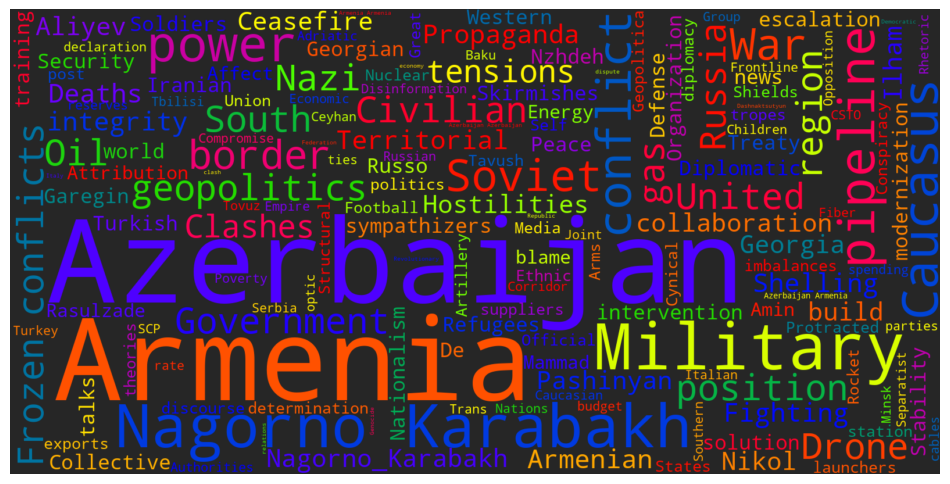

In [23]:
# Keywords list
KeyWords = KeyWordsDF2['Keyword'].tolist()
print(KeyWords)

# Create a word cloud from the keywords
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, colormap="prism", background_color="#262626").generate(' '.join(KeyWords))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [24]:
# Time to select the keywords to use for the data collection by web scraping across sources
# The keywords are selected if the Search Volume is greater than 0.7

KeyWordsDF2 = KeyWordsDF2[KeyWordsDF2['Search Volume'] >= 0.7]
KeyWordsDF2 = KeyWordsDF2.reset_index(drop=True)
KeyWordsDF2.count()

Keyword              37
Search Intent        37
Search Volume        37
Keyword Frequency    37
dtype: int64

['Armenia Nagorno-Karabakh conflict', 'Armenia Nagorno Karabakh', 'Armenia Nagorno-Karabakh', 'Armenia-Azerbaijan', 'Azerbaijan', 'Armenia', 'Armenia Fighting', 'Armenia Propaganda', 'Armenia military', 'Azerbaijan military', 'Armenia and Azerbaijan', 'Armenia Shelling', 'Armenia Conflict', 'Armenia Civilians', 'Armenia War', 'Armenia Deaths', 'Armenian Genocide', 'Armenia Territorial integrity', 'Armenia Nagorno_Karabakh', 'Armenia Hostilities', 'Armenia Military build-up', 'Armenia Caucasus', 'Azerbaijan Nagorno-Karabakh conflict', 'Azerbaijan Nagorno Karabakh', 'Azerbaijan Nagorno-Karabakh', 'Azerbaijan Fighting', 'Azerbaijan Propaganda', 'Azerbaijan Shelling', 'Azerbaijan Conflict', 'Azerbaijan Civilians', 'Azerbaijan War', 'Azerbaijan Deaths', 'Azerbaijan Territorial integrity', 'Azerbaijan Nagorno_Karabakh', 'Azerbaijan Hostilities', 'Azerbaijan Military build-up', 'Azerbaijan Caucasus']


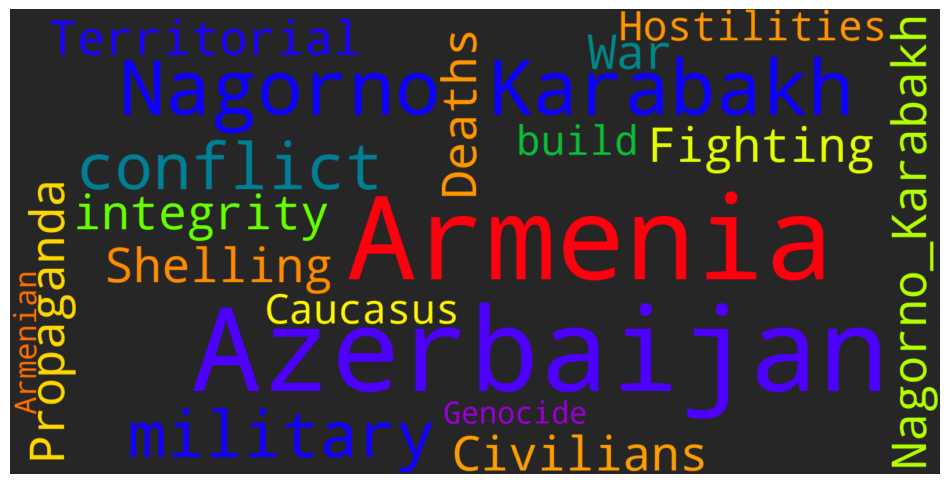

In [25]:
# Keywords list
KeyWords = KeyWordsDF2['Keyword'].tolist()
print(KeyWords)

# Create a word cloud from the keywords
wordcloud = WordCloud(width=1600, height=800, max_font_size=200, colormap="prism", background_color="#262626").generate(' '.join(KeyWords))
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

##### Can't use Twitter API as it is Paid, $100 per month thanks to Elon Musk :)

In [18]:
# Twitter API Credentials
API_KEY = 'I0YJ2KCkpX5zMLBsiXWg8oIpm'
API_SECRET_KEY = 'B0smJRkFAcX702HTqzk2SjmlOn3ODze5HepNqnv15xprtyLIeO'
ACCESS_TOKEN = '1714199019898241024-kc26PuFJ9YOlgQddlxTuvLcRpACqKT'
ACCESS_TOKEN_SECRET = '1tPZmQtSvc1IiY5tnUIEFKBS8IuXZoMKU9PdXuSsyLZso'

# Authenticate with Tweepy
auth = tw.OAuth1UserHandler(
    consumer_key=API_KEY,
    consumer_secret=API_SECRET_KEY,
    access_token=ACCESS_TOKEN,
    access_token_secret=ACCESS_TOKEN_SECRET
)

api = tw.API(auth)

In [ ]:
numberOfTweets = 2
tweets = []

for tweet in tw.Cursor(api.search_tweets, q=KeyWords, lang="en").items(numberOfTweets):
    tweets.append(tweet)

In [ ]:
data = {'Tweet': [], 'Time': []}
for tweet in tweets:
    data['Tweet'].append(tweet.text)
    data['Time'].append(tweet.created_at)

df = pd.DataFrame(data)

##### Reddit

In [30]:
# Reddit App Credentials
CLIENT_ID = 'mPppFSzc3O_wFZzkWt61LA'
CLIENT_SECRET = 'eObtVXwrmq68OS89P5fWWADOzUWC9w'
USER_AGENT = 'web app by /u/Confident-Common3839'

# Authenticate with PRAW
reddit = praw.Reddit(
    client_id=CLIENT_ID,
    client_secret=CLIENT_SECRET,
    user_agent=USER_AGENT
)

count = 0
df_reddit = pd.DataFrame(columns=['Date', 'Topic', 'Sub Topic'])  # Create an empty DataFrame with columns
numberOfRedditPosts = 1000

for count in range(0, len(KeyWords)):
    # Search for posts containing a specific keyword across all of Reddit
    query = KeyWords[count]
    for post in reddit.subreddit('all').search(query, limit=numberOfRedditPosts):
        date = datetime.datetime.fromtimestamp(post.created_utc).strftime('%Y-%m-%d')
        new_row = pd.DataFrame({'Date': date, 'Topic': post.title, 'Sub Topic': post.selftext}, index=[0])
        df_reddit = pd.concat([df_reddit, new_row], ignore_index=True)

In [32]:
df_reddit.drop_duplicates(subset=['Topic'], keep='first', inplace=True)
print(df_reddit.count())
df_reddit.head(5)

Date         4174
Topic        4174
Sub Topic    4174
dtype: int64


,Date,Topic,Sub Topic
0,2023-09-24,"Nagorno-Karabakh's 120,000 Armenians will leav...",
1,2023-09-24,"Nagorno-Karabakh's 120,000 Armenians will leav...",
2,2020-10-01,Conflict in Nagorno-Karabakh (Armenia vs Azerb...,
3,2020-09-29,Conflict in the Caucasus - Nagorno-Karabakh [OC],
4,2020-09-27,Azerbaijan and Armenia clash over disputed Nag...,


##### New York Times

In [28]:
import requests

# NYT API Key
API_KEY = '9NUbrFPCCZLBA292z2H4IGSJprHb7AGT'

# Base URL for Article Search API
BASE_URL = "https://api.nytimes.com/svc/search/v2/articlesearch.json"

df_NYT = pd.DataFrame(columns=['Date', 'Topic'])  # Create an empty DataFrame with columns

count = 0
for count in range(0, len(KeyWords)):
    for i in range(0, 8): #scrape 8 pages
        params = {
        'q': KeyWords[count],  # Search terms
        'api-key': API_KEY,
        'page': i }
        response = requests.get(BASE_URL, params=params)

        # Check if the request was successful
        if response.status_code == 200:
            docs = response.json().get('response').get('docs')
            for doc in docs:
                # print(doc['headline']['main'])  # Print the headline of the article
                # print(doc['web_url'])           # Print the URL of the article
                # print(doc['pub_date'])          Print the publish date of the article
                #convert the date to a date only format
                date = datetime.datetime.strptime(doc['pub_date'], '%Y-%m-%dT%H:%M:%S%z').strftime('%Y-%m-%d')
                # print(date)
                #Append to the dataframe
                new_row = pd.DataFrame({'Date': [date], 'Topic': [doc['headline']['main']]})
                df_NYT = pd.concat([df_NYT, new_row], ignore_index=True)

In [33]:
print(df_NYT.count())
df_NYT.head(5)

Date     350
Topic    350
dtype: int64


,Date,Topic
0,2023-10-09,We Just Saw What the World Is About to Become
1,2023-09-26,Death Toll Rises After Explosion at Nagorno-Ka...
2,2023-09-21,"After Surrender in Nagorno-Karabakh, Leaders D..."
3,2023-09-19,Azerbaijan Begins a Military Operation in Nago...
4,2023-09-29,Armenia: Cast Adrift in a Tough Neighborhood


# Step 2: Post Processing

##### Using LLMs for Topic Relevance Detection

In [34]:
#Creating empty df
df = pd.DataFrame(columns=['Date', 'Topic', 'Sub Topic'])

#Combining all the dataframes into one main dataframe
df = pd.concat([df, df_reddit, df_NYT], ignore_index=True)
# Delete rows which do not have a proper date format
for i in range(0, len(df)):
    try:
        datetime.datetime.strptime(df['Date'][i], '%Y-%m-%d')
    except ValueError:
        df.drop([i], inplace=True)

# Remove duplicate rows
df = df.drop_duplicates(subset=['Topic'], keep='first')

In [36]:
#save the dataframe to a csv file in the temp_files folder
df.to_csv('temp_files/df.csv', index=False)

df = pd.read_csv('temp_files/df.csv')

print(df.count())
df.head(-3)

Date         4382
Topic        4382
Sub Topic     897
dtype: int64


,Date,Topic,Sub Topic
0,2023-09-24,"Nagorno-Karabakh's 120,000 Armenians will leav...",NaN
1,2023-09-24,"Nagorno-Karabakh's 120,000 Armenians will leav...",NaN
2,2020-10-01,Conflict in Nagorno-Karabakh (Armenia vs Azerb...,NaN
3,2020-09-29,Conflict in the Caucasus - Nagorno-Karabakh [OC],NaN
4,2020-09-27,Azerbaijan and Armenia clash over disputed Nag...,NaN
...,...,...,...
4374,1965-04-30,BUILD-UP OF SEATO URGED AT PARLEY,NaN
4375,1966-08-30,Build-Up Report Discussed,NaN
4376,1959-05-07,RED BUILD-UP REPORTED; Taiwan Notes New Milita...,NaN
4377,1955-11-15,A Survey of the Continued Communist Military B...,NaN


In [ ]:
# Load the data from the csv file
df = pd.read_csv('temp_files/df.csv')

###### Using an open-source library called Llama-2 7b, we are implementing quantization to reduce the bit depth to 4 bits in order to achieve faster response times. While this sacrifice may affect the quality of the response, it is acceptable since the response required for our use case is a binary value. Additionally, we have developed a prompt to classify each title and determine its relevance to our topic and target audience.

###### Initially, we conducted tests using other Llama models, specifically the 13b model fine-tuned for instructions. However, the average response time for these models was approximately 30 seconds. In contrast, our current model yields a response time of around 3 seconds, which is significantly faster. This is a must as we have to run it on each row (roughly 4,500 rows)

In [11]:
from transformers import AutoTokenizer, pipeline, logging
from auto_gptq import AutoGPTQForCausalLM, BaseQuantizeConfig
import time

model_name_or_path = "TheBloke/Llama-2-7b-Chat-GPTQ"
model_basename = "model"

use_triton = False

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=False)

model = AutoGPTQForCausalLM.from_quantized(model_name_or_path,
        model_basename=model_basename,
        use_safetensors=True,
        trust_remote_code=True,
        device="cuda:0",
        use_triton=use_triton,
        quantize_config=None)



# Prevent printing spurious transformers error when using pipeline with AutoGPTQ
logging.set_verbosity(logging.CRITICAL)

pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=512,
    temperature=0.,
    top_p=0.95,
    repetition_penalty=1.15
)

skip module injection for FusedLlamaMLPForQuantizedModel not support integrate without triton yet.


In [ ]:
# Going through each row in the dataframe and asking the LLM if the topic is related to Armenia Conflict/war with Azerbaijan or not. If there is a topic and subtopic, we will combine them and ask the LLM. If the LLM says yes, we will append the row to a new dataframe.
df_cleaned = pd.DataFrame(columns=['Date', 'Topic', 'Sub Topic', 'related to conflict'])
current = 0
for index, row in df.iterrows():
    if pd.isnull(row['Sub Topic']):
        prompt = row['Topic']
    else:
        prompt = row['Topic'] + " " + row['Sub Topic']
    prompt_template=f'''[INST] <<SYS>>
    {system_message}
    <</SYS>>

    {prompt} [/INST]'''
    response = pipe(prompt_template)
    x = response[0]['generated_text']
    x = x.lower()
    if 'yes' in x:
        new_row = pd.DataFrame({'Date': [row['Date']], 'Topic': [row['Topic']], 'Sub Topic': [row['Sub Topic']], 'related to conflict': [1]})
        df_cleaned = pd.concat([df_cleaned, new_row], ignore_index=True)
    elif 'no' in x:
        new_row = pd.DataFrame({'Date': [row['Date']], 'Topic': [row['Topic']], 'Sub Topic': [row['Sub Topic']], 'related to conflict': [0]})
        df_cleaned = pd.concat([df_cleaned, new_row], ignore_index=True)
    else:
        print("Error")

    if current % 100 == 0:
        print(current)

In [101]:
#LOAD THE DATAFRAME
df_cleaned = pd.read_csv('temp_files/df_cleaned.csv')

In [102]:
# Drop all the rows which topic is nul
df_cleaned = df_cleaned.dropna(subset=['Topic'])

# Only keep the rows that are related to the conflict
df_cleaned = df_cleaned[df_cleaned['related to conflict'] == 1]
df_cleaned = df_cleaned.reset_index(drop=True)

# Delete duplicate rows
df_cleaned = df_cleaned.drop_duplicates(subset=['Topic'], keep='first')

print(df_cleaned.count())
df_cleaned.head()

Date                   1621
Topic                  1621
Sub Topic               241
related to conflict    1621
dtype: int64


,Date,Topic,Sub Topic,related to conflict
0,9/24/2023,"Nagorno-Karabakh's 120,000 Armenians will leav...",NaN,1.0
1,9/24/2023,"Nagorno-Karabakh's 120,000 Armenians will leav...",NaN,1.0
2,10/1/2020,Conflict in Nagorno-Karabakh (Armenia vs Azerb...,NaN,1.0
3,9/29/2020,Conflict in the Caucasus - Nagorno-Karabakh [OC],NaN,1.0
4,9/27/2020,Azerbaijan and Armenia clash over disputed Nag...,NaN,1.0


###### Resampling the Data Set

In [103]:
# Combine the topic and subtopic into one column
df_cleaned['Topic'] = df_cleaned['Topic'].fillna('') + ' ' + df_cleaned['Sub Topic'].fillna('')
df_cleaned = df_cleaned.drop(['Sub Topic'], axis=1)


###### Labeling the Data: Identifying Global Crisis

In [104]:
# create a new column called target
df_cleaned['target'] = np.nan

# if the date is before September 27 label 0 and if it is after or on September 27 label 1 (in column called target)
for index, row in df_cleaned.iterrows():
    if row['Date'] < '2020-09-27':
        df_cleaned.loc[index, 'target'] = 0
    else:
        df_cleaned.loc[index, 'target'] = 1

#drop the related to conflict column
df_cleaned = df_cleaned.drop(columns=['related to conflict'])

In [105]:
# Check how much content from each year (not date) we have
df_cleaned['Date'] = pd.to_datetime(df_cleaned['Date'])
df_cleaned['Date'] = df_cleaned['Date'].dt.year
df_cleaned['Date'].value_counts()

Date
2023    879
2022    291
2020    275
2021    106
2016     28
2019     16
2018     10
2017      7
2015      4
2014      1
2013      1
2003      1
2011      1
2006      1
Name: count, dtype: int64

In [106]:
# Removing outliers from the dataset (all years less then 2019)
df_cleaned = df_cleaned[df_cleaned['Date'] >= 2019]
df_cleaned = df_cleaned.reset_index(drop=True)

In [107]:
df_cleaned.count()

Date      1567
Topic     1567
target    1567
dtype: int64

In [108]:
print(df_cleaned['target'].value_counts())

target
1.0    1069
0.0     498
Name: count, dtype: int64


##### Feature Engineering

In [109]:
# Dropping the date column
df_cleaned = df_cleaned.drop(columns=['Date'])

###### Performing sentimental analysis

In [110]:
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

In [111]:
sid = SIA()

# Create a new column called sentiment
df_cleaned['sentiment'] = np.nan

for index, row in df_cleaned.iterrows():
    sentiment = sid.polarity_scores(row['Topic'])
    if sentiment['compound'] >= 0.06:
        df_cleaned.loc[index, 'sentiment'] = 1
    elif sentiment['compound'] <= 0.035:
        df_cleaned.loc[index, 'sentiment'] = -1
    else:
        df_cleaned.loc[index, 'sentiment'] = 0

In [112]:
df_cleaned.head()

,Topic,target,sentiment
0,"Nagorno-Karabakh's 120,000 Armenians will leav...",1.0,-1.0
1,"Nagorno-Karabakh's 120,000 Armenians will leav...",1.0,-1.0
2,Conflict in Nagorno-Karabakh (Armenia vs Azerb...,0.0,-1.0
3,Conflict in the Caucasus - Nagorno-Karabakh [OC],1.0,-1.0
4,Azerbaijan and Armenia clash over disputed Nag...,1.0,-1.0


In [113]:
KeyWordsCSV = pd.read_csv('KeyWords.csv')
KeyWordsDF = pd.DataFrame(KeyWordsCSV)
# Sort by Search Volume in descending order
KeyWordsDF = KeyWordsDF.sort_values(by=['Search Volume'], ascending=False)
KeyWordsDF = KeyWordsDF.drop(KeyWordsDF.columns[0], axis=1)
KeyWordsDF = KeyWordsDF.dropna()

In [114]:
# Standardize the "Topic" by lowercasing, removing punctuation and replacing dash with spaces. Also removing 's from the end of words
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    df[text_field] = df[text_field].str.replace(r'[^\w\s]+', '')
    df[text_field] = df[text_field].str.replace(r'-', ' ')
    df[text_field] = df[text_field].str.replace(r'\'s', '')
    return df

df_cleaned = standardize_text(df_cleaned, "Topic")

In [115]:
KeyWordsCSV = pd.read_csv('KeyWords.csv')
KeyWordsDF = pd.DataFrame(KeyWordsCSV)
KeyWordsDF = KeyWordsDF.sort_values(by=['Search Volume'], ascending=False)
KeyWordsDF = KeyWordsDF.drop(KeyWordsDF.columns[0], axis=1)
KeyWordsDF = KeyWordsDF.dropna()

KeyWordsList = KeyWordsDF['Keyword'].tolist()

# Standardize the "Keyword" by lowercasing, removing punctuation and replacing dash with spaces. Also removing 's from the end of words
for i in range(0, len(KeyWordsList)):
    KeyWordsList[i] = KeyWordsList[i].lower()
    KeyWordsList[i] = KeyWordsList[i].replace(r'[^\w\s]+', '')
    KeyWordsList[i] = KeyWordsList[i].replace(r'-', ' ')
    KeyWordsList[i] = KeyWordsList[i].replace(r'\'s', '')

# Remove duplicates from the list
KeyWordsList = list(dict.fromkeys(KeyWordsList))

print(KeyWordsList)

['nagorno karabakh conflict', 'nagorno karabakh', 'armenia azerbaijan', 'azerbaijan', 'armenia', 'fighting', 'propaganda', 'armenia military', 'azerbaijan military', 'armenia and azerbaijan', 'shelling', 'conflict', 'civilians', 'war', 'deaths', 'armenian genocide', 'territorial integrity', 'nagorno_karabakh', 'hostilities', 'military build up', 'caucasus', 'ilham aliyev', 'south caucasus', 'nikol pashinyan', 'georgia', 'ceasefire', 'nazi collaboration', 'nazi sympathizers', 'russia', 'armenia azerbaijan clashes', 'clashes', 'iranian intervention in the caucasus', 'collective security treaty organization', 'russo georgian war', 'de escalation', 'civilian', 'skirmishes', 'military positions', 'defense', 'frozen conflicts', 'diplomatic solution', 'soldiers', 'refugees', 'peace talks', 'stability', 'nagorno karabakh tensions', 'nagorno karabakh news', 'turkish world', 'military modernization', 'western powers', 'military training', 'garegin nzhdeh', 'nationalism', 'attribution of blame', 

In [116]:
df_final = df_cleaned.copy()

# Add a word count column
df_final['word count'] = df_final['Topic'].str.split().str.len()

# Every word in KeyWordList is to be made into a column in the dataframe
for word in KeyWordsList:
    df_final[word] = 0

# Go through each topic and count the number of times each keyword appears in the topic and then add that number to the corresponding column
for index, row in df_final.iterrows():
    for word in KeyWordsList:
        df_final.loc[index, word] = row['Topic'].count(word)

# Remove all the columns which all rows have a value of 0
df_final = df_final.loc[:, (df_final != 0).any(axis=0)]

# Remove the Topic column
df_final = df_final.drop(columns=['Topic'])

df_final.head()

,target,sentiment,word count,nagorno karabakh conflict,nagorno karabakh,armenia azerbaijan,azerbaijan,armenia,fighting,propaganda,...,truce,smerch missiles,troika,cluster bombs,mortars,nagorno karabakh autonomous oblast,cease fire,envoys,buffer zone,atrocities
0,1.0,-1.0,10,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1.0,-1.0,10,0,1,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,-1.0,7,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1.0,-1.0,7,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1.0,-1.0,9,0,1,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [117]:
# Saving the dataframe to a csv file
df_final.to_csv('temp_files/df_final.csv', index=False)

# Step 3: Fitting a model

##### Neural Network

In [175]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import accuracy_score, classification_report
from keras.callbacks import EarlyStopping

# Load your dataset
df = pd.read_csv('temp_files\df_final.csv')

# Define the features (X) and the target (y)
X = df.drop(columns=['crisis'])
y = df['crisis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

model = Sequential()

# Add input layer and hidden layers
model.add(Dense(units=64, activation='relu', input_dim=X_train.shape[1]))  # Adjust the number of units as needed
model.add(Dense(units=32, activation='relu'))
model.add(Dense(units=16, activation='relu'))

# Add output layer (sigmoid activation for binary classification)
model.add(Dense(units=1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=60)

# Train the model with early stopping
model.fit(X_train, y_train, epochs=350, batch_size=4, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Make predictions on the test data
y_pred = (model.predict(X_test) > 0.5).astype(int)

# Evaluate the neural network model
accuracy_nn = accuracy_score(y_test, y_pred)
classification_report_result_nn = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_nn:.2f}")
print("Classification Report:")
print(classification_report_result_nn)

Epoch 1/350
314/314 [==============================] - 1s 2ms/step - loss: 0.6365 - accuracy: 0.6664 - val_loss: 0.5826 - val_accuracy: 0.7325
Epoch 2/350
314/314 [==============================] - 0s 1ms/step - loss: 0.5764 - accuracy: 0.7159 - val_loss: 0.5788 - val_accuracy: 0.7325
Epoch 3/350
314/314 [==============================] - 0s 2ms/step - loss: 0.5559 - accuracy: 0.7279 - val_loss: 0.5797 - val_accuracy: 0.7293
Epoch 4/350
314/314 [==============================] - 0s 2ms/step - loss: 0.5385 - accuracy: 0.7406 - val_loss: 0.5987 - val_accuracy: 0.7134
Epoch 5/350
314/314 [==============================] - 0s 1ms/step - loss: 0.5310 - accuracy: 0.7510 - val_loss: 0.5836 - val_accuracy: 0.7293
Epoch 6/350
314/314 [==============================] - 0s 1ms/step - loss: 0.5262 - accuracy: 0.7470 - val_loss: 0.5908 - val_accuracy: 0.7261
Epoch 7/350
314/314 [==============================] - 0s 2ms/step - loss: 0.5119 - accuracy: 0.7526 - val_loss: 0.5984 - val_accuracy: 0.7197

##### Random Forest Classifier

In [142]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset
df = pd.read_csv('temp_files\df_final.csv')

# Define the features (X) and the target (y)
X = df.drop(columns=['crisis'])
y = df['crisis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the classifier to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy_rf = accuracy_score(y_test, y_pred)
classification_report_result_rf = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_rf:.2f}")
print("Classification Report:")
print(classification_report_result_rf)

Accuracy: 0.67
Classification Report:
              precision    recall  f1-score   support

         0.0       0.40      0.30      0.34        91
         1.0       0.74      0.82      0.78       223

    accuracy                           0.67       314
   macro avg       0.57      0.56      0.56       314
weighted avg       0.64      0.67      0.65       314



##### Logistic Regression


In [176]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Load your dataset
df = pd.read_csv('temp_files\df_final.csv')

# Define the features (X) and the target (y)
X = df.drop(columns=['crisis'])
y = df['crisis']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Logistic Regression model
logistic_reg = LogisticRegression(random_state=42)

# Fit the model to the training data
logistic_reg.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logistic_reg.predict(X_test)

# Evaluate the logistic regression model
accuracy_lr = accuracy_score(y_test, y_pred)
classification_report_result_lr = classification_report(y_test, y_pred)

# Print the evaluation metrics
print(f"Accuracy: {accuracy_lr:.2f}")
print("Classification Report:")
print(classification_report_result_lr)

Accuracy: 0.73
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.08      0.14        91
         1.0       0.72      0.99      0.84       223

    accuracy                           0.73       314
   macro avg       0.75      0.53      0.49       314
weighted avg       0.74      0.73      0.64       314



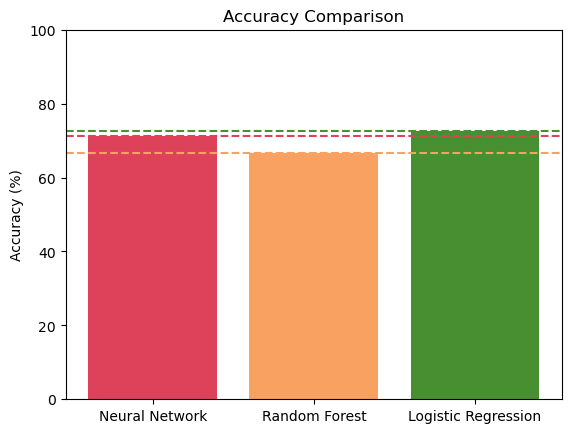

In [178]:
# Visualizing the accuracy and classification report of the 3 models

labels = ['Neural Network', 'Random Forest', 'Logistic Regression']

accuracy_scores = [accuracy_nn, accuracy_rf, accuracy_lr]
accuracy_scores = [num * 100 for num in accuracy_scores]
plt.bar(labels, accuracy_scores, color=["#de425b", "#f9a160", "#488f31"])
plt.ylim(0, 100)
plt.axhline(y=accuracy_nn * 100, color='#de425b', linestyle='--')
plt.axhline(y=accuracy_rf * 100, color='#f9a160', linestyle='--')
plt.axhline(y=accuracy_lr * 100, color='#488f31', linestyle='--')
plt.title('Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.show()

In [177]:
# Saving the Logistic Regression model as it has the highest accuracy
import pickle

# Save the model
with open('temp_files\logistic_regression_model.pkl', 'wb') as file:
    pickle.dump(logistic_reg, file)

# Save the scaler
with open('temp_files\scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

# Save the list of keywords
with open('temp_files\keywords.pkl', 'wb') as file:
    pickle.dump(KeyWordsList, file)